In [ ]:
#all_slow

In [ ]:
# default_exp johnson2016perceptual

# Perceptual losses for real-time style transfer and super-resolution

Johnson, J., Alahi, A., & Fei-Fei, L. (2016, October). Perceptual losses for real-time style transfer and super-resolution. In European conference on computer vision (pp. 694-711). Springer, Cham.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from itertools import *
import requests
from scipy import linalg
import torch
from torchvision.models.utils import load_state_dict_from_url
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.data.external import untar_data
from fastai.data.transforms import get_image_files
from fastai.data import *
from fastai.basics import *
from fastai.vision.all import *
#from fastai.vision.data import *
#from fastai.vision.core import *
from fastcore.all import *
#from fastai.vision.augment import *
from fastai.vision.gan import *
from fastai.callback.hook import *
from fastai.callback.progress import *
from fastpapers.core import *
import torch.nn.functional as F

## The data

In [ ]:
path = untar_data(URLs.IMAGENETTE)

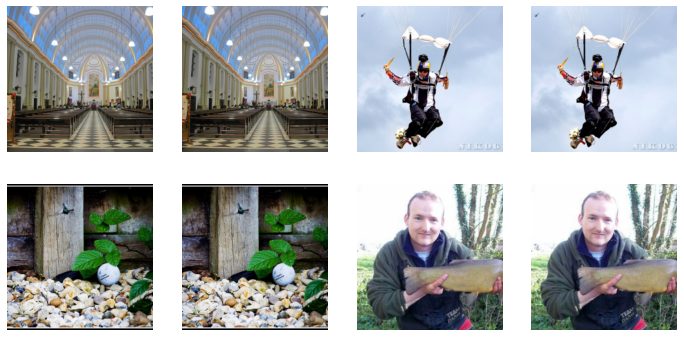

In [ ]:
db = DataBlock(blocks=(ImageBlock, ImageBlock),
               get_items=get_image_files,
               get_x=noop, get_y=noop,
               item_tfms=Resize(256),
               batch_tfms=Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)))
dls = db.dataloaders(path, bs=4, num_workers=4)
dls.show_batch()

For style transfer we have to choose any image as a style target and normlalize it with the `imagenet_stats`.

In [ ]:
urls = {'picasso': 'https://i.pinimg.com/originals/45/e1/c2/45e1c21835ef2bd9b0f4b1a9a0a6ad98.jpg',
        'hokusai': 'https://canary.contestimg.wish.com/api/webimage/58db571f2beb150ea4d4be44-large.jpg?cache_buster=6748460fdd0b539b8f6366f7f86cc267',
        'vanGogh': 'https://images-na.ssl-images-amazon.com/images/I/61vvPgDP7hL._AC_.jpg'}

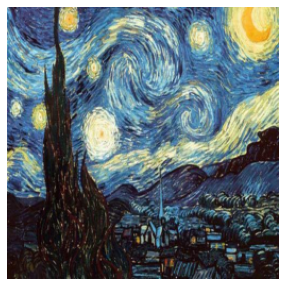

In [ ]:
artist = 'vanGogh'
r = requests.get(urls[artist], stream=True)
style_target = PILImage.create(r.content)
p = Pipeline([ToTensor, Resize(256,  ResizeMethod.Squish), IntToFloatTensor, Normalize.from_stats(*imagenet_stats, cuda=False)])
style_target = p(style_target)
batch_to_samples(p.decode(style_target))[0].show();

## The Loss

As the autors extracted features from the VGG16 model.

In [ ]:
#export
vgg16 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=False).features
c, i, j =0, 0, 1
vgg16name2key = {}
for k, l in vgg16._modules.items():
    if isinstance(l, nn.MaxPool2d): j, i, c = j + 1, 0, 0
    if isinstance(l, nn.ReLU):
        i+=1
        vgg16name2key[f'relu{j}_{i}'] = k

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


The `PerceptualLoss` module computes the feature loss based on `feture_layer` and the style loss on the  `style_layers_names`.

In [ ]:
#export
class PerceptualLoss(nn.Module):
    def __init__(self, style_target=None, style_weight=1, feature_weight=1, renormalize=True,
                 feature_layer='relu2_2', style_layers_names=['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'],
                 bs=1):
        super().__init__()
        store_attr()
        self.vgg16 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True).features.eval()
        self.vgg16 = self.vgg16.requires_grad_(False)
        self.feature_layer = self.vgg16._modules[vgg16name2key[feature_layer]]
        self.renorm = Normalize.from_stats(*renorm_stats, cuda=False) if renormalize else noop
        self.compute_style = not style_target is None
        if self.compute_style:
            self.setup_style()

    def to(self, *args, **kwargs):
        if self.renormalize:
            self.renorm.mean = self.renorm.mean.to(*args, **kwargs)
            self.renorm.std = self.renorm.std.to(*args, **kwargs)
        if self.compute_style:
            self.Gts = [G.to(*args, **kwargs) for G in self.Gts]
        return super().to(*args, **kwargs)
        
    def setup_style(self):
        self.style_layers = L(self.style_layers_names).map(vgg16name2key).map(self.vgg16._modules)
        self.style_target = nn.Parameter(self.style_target, requires_grad=False)
        with Hooks(self.style_layers, lambda m,i,o: o, detach=False) as h:
            y = self.vgg16(self.style_target)
            self.Gts = []
            for phi in h.stored:
                phi = phi.view(phi.shape[0], phi.shape[1], -1)
                G = torch.bmm(phi, phi.transpose(1,2))
                Gr = (G/(phi.shape[1]*phi.shape[2])).repeat(self.bs, 1, 1)
                self.Gts.append(nn.Parameter(Gr.detach(), requires_grad=False))

    def feature_loss(self, output, target):
        with Hook(self.feature_layer, lambda m,i,o: o, detach=False) as h:
            self.vgg16(output)
            phi_input = h.stored[0]
            self.vgg16(target)
            phi_target = h.stored[0]
        return nn.MSELoss(reduction='mean')(phi_input, phi_target)

    def style_loss(self, output, target):
        with Hooks(self.style_layers, lambda m,i,o: o, detach=False) as h:
            self.vgg16(output)
            self.Gis = []
            for phi in h.stored:
                phi = phi.view(phi.shape[0], phi.shape[1], -1)
                G = torch.bmm(phi, phi.transpose(1,2))
                self.Gis.append(G/(phi.shape[1]*phi.shape[2]))
        return sum([nn.MSELoss(reduction='sum')(Gi, Gt[:Gi.shape[0]]) for Gi, Gt in zip(self.Gis, self.Gts)])/output.shape[0]
    
    def forward(self, output, target):
        output = self.renorm(output)
        target = self.renorm(target)
        feature_loss = self.feature_loss(output, target)
        style_loss = self.style_loss(output, target) if self.compute_style else tensor(0)
        return feature_loss*self.feature_weight + style_loss*self.style_weight

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True, style_weight=1, bs=4).to('cuda')
input = TensorImage(torch.rand(2, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(2, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


TensorImage(202.4777, device='cuda:0')

Test that the style image is properly normalized

In [ ]:
style_unnorm = TensorImage(torch.rand(1, 3, 256, 256))
style_imagenet = Normalize.from_stats(*imagenet_stats, cuda=False)(style_unnorm)
style_norm = style_unnorm*2-1 
feature_loss = PerceptualLoss(style_imagenet, renormalize=True, feature_weight=0)
target = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
loss = feature_loss(style_norm, target)
test_eq(loss, 0)

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True).to('cuda')
input = TensorImage(torch.rand(1, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(1, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


TensorImage(204.9990, device='cuda:0')

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True).to('cuda')
input = TensorImage(torch.rand(1, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(1, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


TensorImage(201.6946, device='cuda:0')

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True, bs=4).to('cuda')
input = TensorImage(torch.rand(4, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(4, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


TensorImage(204.3408, device='cuda:0')

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True, style_weight=1e5, feature_weight=1).to('cuda')
target = TensorImage(torch.rand(1, 3, 256, 256)*2-1).to('cuda')
loss = feature_loss(target, target)
loss

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


TensorImage(17384292., device='cuda:0')

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True, style_weight=1, bs=4).to('cuda')
input = TensorImage(torch.rand(4, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(4, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


TensorImage(201.3080, device='cuda:0')

## Resnet Generator

The authors use a generator with residual connexions. They used a residual block without the last activation.

In [ ]:
#export
class JohnsonResBlock(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.convpath = nn.Sequential(ConvLayer(n, n, 3, padding_mode='reflect'),
                                       ConvLayer(n, n, 3, padding_mode='reflect', act_cls=None))
    def forward(self, x):
        return self.convpath(x)+x    

In [ ]:
jrb = JohnsonResBlock(32)
x = torch.randn(4, 32, 16, 16)
y = jrb(x)
test_eq(y.shape, x.shape)

In [ ]:
#export
def ResnetGenerator(ni=3, nout=3, nf=32, n_downsamples=2, n_resblocks=5, n_upsamples=2, superres=False):
    layers = [ConvLayer(ni, nf, 9, padding_mode='reflect')]
    for i in range(n_downsamples):
        layers.append(ConvLayer(nf, nf*2, 3, padding_mode='reflect', stride=2))
        nf*=2
    for i in range(n_resblocks):
        layers.append(JohnsonResBlock(nf))
    for i in range(n_upsamples):
        nout = nf if superres else nf//2
        layers.append(ConvLayer(nf, nout, 3, transpose=True, stride=2, output_padding=1, padding=1))
        if not superres: nf//=2
    layers.append(ConvLayer(nf, 3,9, padding_mode='reflect', act_cls=None))
    layers.append(nn.Tanh())
    return nn.Sequential(*layers)

In [ ]:
#hide
style_transfer_generator = ResnetGenerator()
model_sizes(style_transfer_generator, (256, 256))

[torch.Size([1, 32, 256, 256]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 32, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256])]

In [ ]:
style_transfer_generator = ResnetGenerator()
x = torch.randn(1, 3, 256, 256)
y = style_transfer_generator(x)
y.shape, y.max(), y.min()

(torch.Size([1, 3, 256, 256]),
 tensor(0.9997, grad_fn=<MaxBackward1>),
 tensor(-0.9999, grad_fn=<MinBackward1>))

## Learning

In [ ]:
#export
class LossToDevice(Callback):
    def before_fit(self):
        if hasattr(self.dls, 'device'): self.loss_func.to(self.dls.device)

In [ ]:
#export
@delegates(Learner)
def style_learner(dls, style_target=None, cbs=None, **kwargs):
    model = ResnetGenerator()
    loss_func = PerceptualLoss(style_target=style_target, bs=dls.bs)
    cbs = L(cbs) + LossToDevice if cbs else LossToDevice
    return Learner(dls, model, loss_func=loss_func, cbs=cbs, **kwargs)

In [ ]:
learn = style_learner(dls, style_target=style_target, cbs=ShowGraphCallback)

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


epoch,train_loss,valid_loss,time
0,5.921388,5.958647,05:27
1,5.197965,5.349996,05:30
2,4.950555,4.936140,05:30


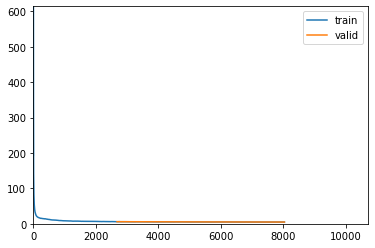

In [ ]:
#hide_output
learn.fit(4, lr=1e-3, wd=0)

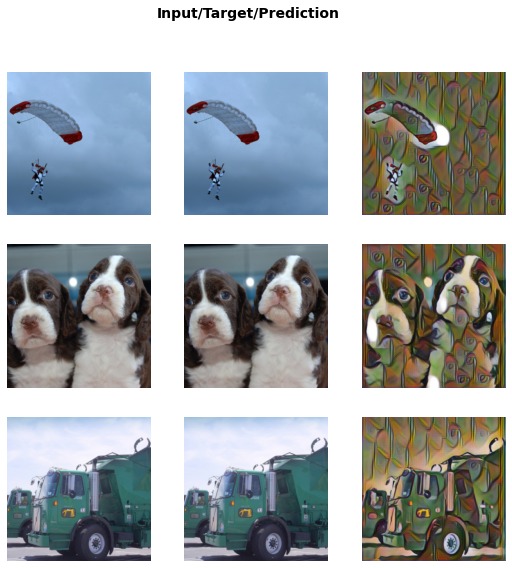

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
#style_learn.export(f'{artist}_style_transfer.pkl')

## Super-Resolution 4x

In [ ]:
# export
def ResImageBlock(res): 
    '''Like fastai `ImageBlock`, but changes the resolution to `res`.'''
    return TransformBlock(type_tfms=[PILImage.create, Resize(res, ResizeMethod.Squish)], batch_tfms=IntToFloatTensor)

In [ ]:
db = DataBlock(blocks=(ResImageBlock(72), ResImageBlock(288)),
               get_items=get_image_files,
               get_x=noop, get_y=noop,
               batch_tfms=Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)))

In [ ]:
#hide_output
dls = db.dataloaders(path, bs=4, num_workers=4)
dls.show_batch()
b = dls.one_batch()

In [ ]:
#export
@delegates(Learner)
def superres_learner(dls, superres_factor=4, cbs=None, **kwargs):
    n_upsamples = math.log2(superres_factor)
    assert n_upsamples-int(n_upsamples)==0, 'superres_factor should be a power of 2'
    model = ResnetGenerator(nf=64, n_downsamples=0, n_resblocks=4, n_upsamples=int(n_upsamples), superres=True)
    loss_func = PerceptualLoss(style_weight=0)
    cbs = L(cbs) + LossToDevice if cbs else LossToDevice
    return Learner(dls, model, loss_func=loss_func, cbs=cbs, **kwargs)

In [ ]:
learn = superres_learner(dls)
learn.fit(16, lr=1e-3, wd=0)

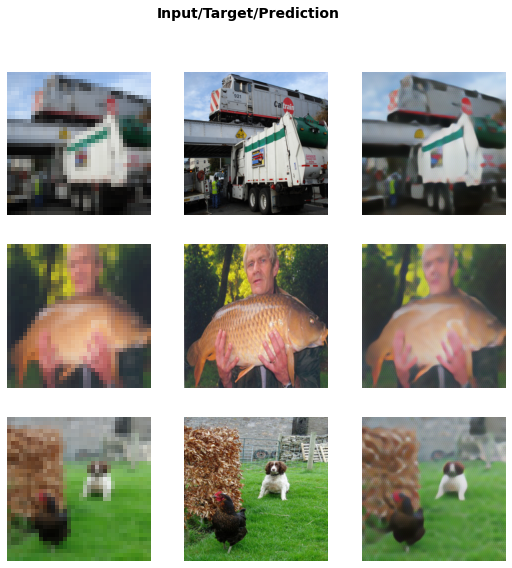

In [ ]:
learn.show_results()

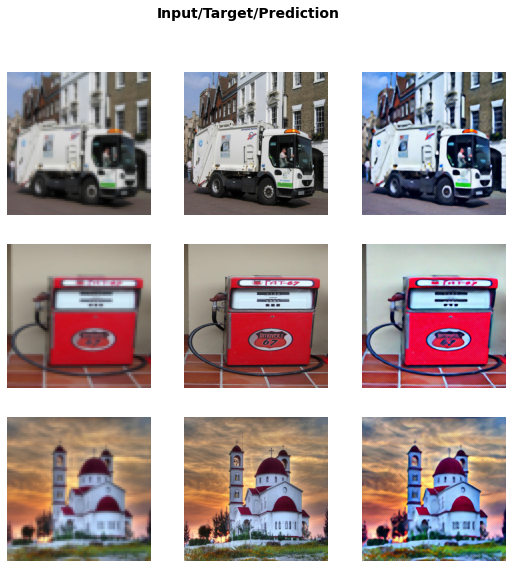

In [ ]:
learn.show_results()

In [ ]:
#learn.export('superresolution4x.pkl')

## Superres 8x

In [ ]:
db = DataBlock(blocks=(ResImageBlock(36), ResImageBlock(288)),
               get_items=get_image_files,
               get_x=noop, get_y=noop,
               batch_tfms=Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)))

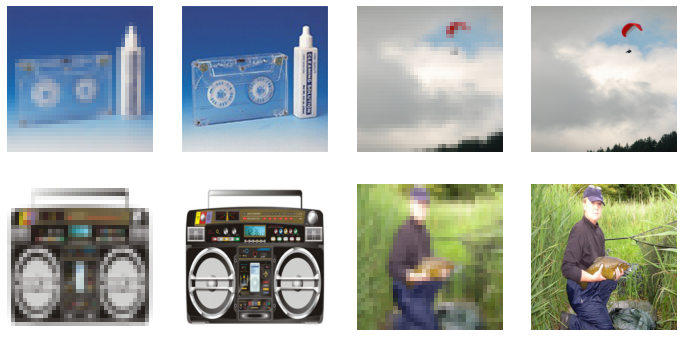

In [ ]:
#hide_output
dls = db.dataloaders(path, bs=4, num_workers=4)
dls.show_batch()
b = dls.one_batch()

In [ ]:
#hide_output
learn = superres_learner(dls, superres_factor=8)
learn.fit(16, lr=1e-3, wd=0)

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


epoch,train_loss,valid_loss,time
0,4.294052,4.436052,04:54
1,4.042668,4.040712,06:55
2,4.074093,3.922117,04:21
3,4.171868,3.879687,04:20
4,3.951751,3.826940,04:20
5,4.021472,3.804607,04:20
6,3.832989,3.793207,04:20
7,3.650093,3.788133,04:20
8,3.538365,3.751862,04:20
9,4.025765,3.753390,04:21


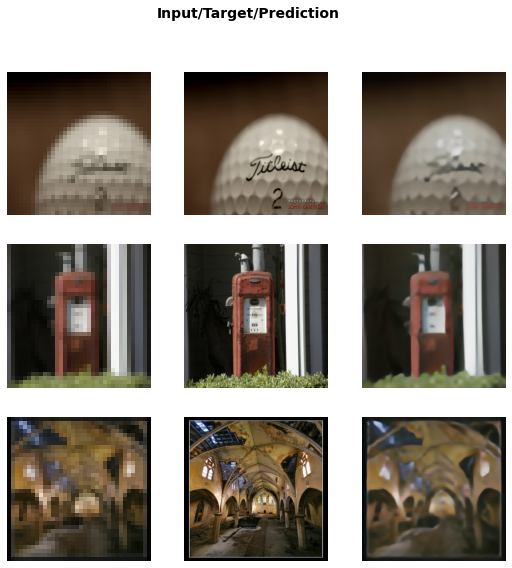

In [ ]:
learn.show_results()

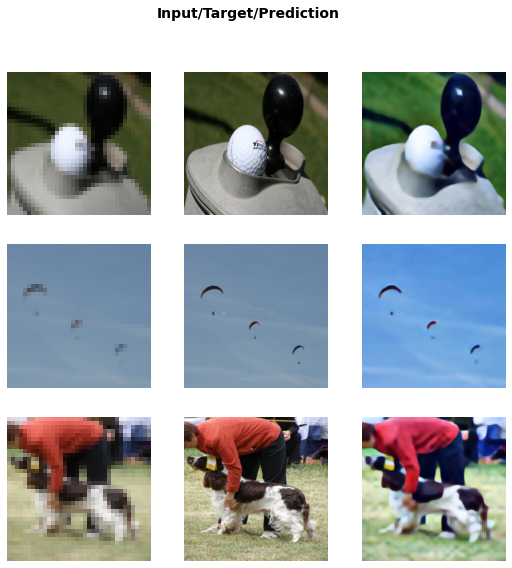

In [ ]:
learn.show_results()

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted 02_heusel2017gans.ipynb.
Converted 03_johnson2016perceptual.ipynb.
Converted index.ipynb.
